In [1]:
import pandas as pd
import numpy as np
import keras
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X_train = (train.iloc[: , 1:].values).astype(np.float)
Y_train = (train.iloc[: , 0].values).astype(np.float)
X_test = (test.values).astype(np.float)

X_train, X_valid, Y_train, Y_valid = train_test_split( X_train, Y_train , test_size= 0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0] , 28 , 28 , 1)
X_test = X_test.reshape(X_test.shape[0] , 28 , 28 , 1)
X_valid = X_valid.reshape(X_valid.shape[0] , 28 , 28 , 1)
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)

X_train /= 255.0 
X_valid /= 255.0
X_test /= 255.0

train_mean = np.average(X_train)
valid_mean = np.average(X_valid)
test_mean = np.average(X_test)

train_variance = np.var(X_train)
valid_variance = np.var(X_valid)
test_variance = np.var(X_test)

X_train -= train_mean
X_valid -= valid_mean
X_test -= test_mean

X_train /= train_variance
X_valid /= valid_variance
X_test /= test_variance


In [3]:
def model(input_shape):
    
    Input = keras.layers.Input(input_shape)
    
    #Layer #1

    X = keras.layers.Conv2D(16, (3,3), strides=(1, 1)  , padding = 'same')(Input)
    X = keras.layers.Conv2D(32, (3,3), strides=(1, 1)  , padding = 'same')(X)
    X = keras.layers.Dropout(0.15)(X)
    X = keras.layers.BatchNormalization(axis = 3)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.AveragePooling2D((2, 2) , 1 )(X)

    #Layer #2
    
    X = keras.layers.Conv2D(32, (3,3), strides=(2, 2) , padding = 'same')(X)
    X = keras.layers.Dropout(0.15)(X)
    X = keras.layers.BatchNormalization(axis = 3)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.AveragePooling2D((2 , 2) , 1)(X)
    
    #Layer #3
     
    X = keras.layers.Conv2D(64, (5,5) , strides=(2,2) ,  padding = "same")(X)
    X = keras.layers.Dropout(0.15)(X)
    X = keras.layers.BatchNormalization(axis = 3)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.AveragePooling2D((2, 2) , 1)(X)
    
    #Layer #4
    
    X = keras.layers.Conv2D(128, (5,5) , strides=(2,2) ,  padding = "same")(X)
    X = keras.layers.Dropout(0.15)(X)
    X = keras.layers.BatchNormalization(axis = 3)(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.AveragePooling2D((2, 2) , 1)(X)
        
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(256 , activation='relu')(X)
    X = keras.layers.Dropout(0.25)(X)
    X = keras.layers.Dense(10 , activation='softmax')(X)

    return keras.models.Model(inputs = Input , outputs = X)
    
    
    

In [4]:
DRmodel = model((28,28,1))

In [5]:
DRmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 27, 27, 32)        0         
__________

In [6]:
from keras.callbacks import Callback
class TrackLoss(Callback):
    def __init__(self):
        
        self.valid_losses = []
        self.train_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.valid_losses.append(logs.get('val_loss'))
        self.train_losses.append(logs.get('loss'))


In [7]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=12,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  


datagen.fit(X_train)

print len(X_train)

37800


In [21]:
DRmodel.fit_generator(datagen.flow(X_train,Y_train, batch_size=64),
                              epochs = 40, validation_data = (X_valid,Y_valid),
                              verbose = 1, steps_per_epoch=len(X_train) // 64
                              , callbacks=[l,lrd])

Epoch 1/40
590/590 [==============================] - 35s 59ms/step - loss: 0.0180 - acc: 0.9946 - val_loss: 0.0190 - val_acc: 0.9943
Epoch 2/40
590/590 [==============================] - 42s 71ms/step - loss: 0.0172 - acc: 0.9945 - val_loss: 0.0191 - val_acc: 0.9945
Epoch 3/40
590/590 [==============================] - 43s 74ms/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0186 - val_acc: 0.9945
Epoch 4/40
590/590 [==============================] - 44s 75ms/step - loss: 0.0187 - acc: 0.9943 - val_loss: 0.0191 - val_acc: 0.9945
Epoch 5/40
590/590 [==============================] - 44s 75ms/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0188 - val_acc: 0.9945
Epoch 6/40
590/590 [==============================] - 45s 77ms/step - loss: 0.0197 - acc: 0.9944 - val_loss: 0.0187 - val_acc: 0.9945
Epoch 7/40
590/590 [==============================] - 45s 77ms/step - loss: 0.0161 - acc: 0.9950 - val_loss: 0.0190 - val_acc: 0.9945
Epoch 8/40
590/590 [==============================] - 45s 77ms

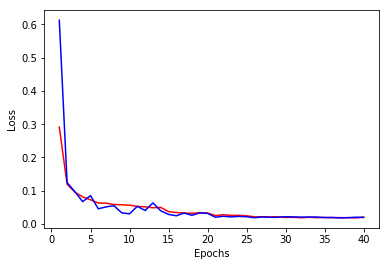

In [15]:
import matplotlib.pyplot as plt
plt.xlabel(
    'Epochs')
plt.ylabel('Loss')

plt.plot(range(1,41) , l.train_losses , '-r' , range(1,41) , l.valid_losses , '-b')
plt.show()

In [26]:
predictions = DRmodel.predict(X_test)
labels = predictions.argmax(axis = 1)

In [27]:
outputs = pd.DataFrame()
outputs['Label'] = labels

In [28]:
outputs.to_csv("Predictions.csv")